# analysis
Analyzing each type of quantum among exponential, uniform, and constant

In [1]:
from glob import glob
import sys, os
import matplotlib.pyplot as plt
import pickle
import numpy as np
import desutils
from functools import reduce
from matplotlib.lines import Line2D

In [3]:
cpu3    = 'batchInteractiveMalloc_constantQ_3cpu/'
cpu1 = 'batchInteractiveMalloc_constantQ_1cpu/'
cpu1_qs = sorted(list(filter(os.path.isdir, glob(os.path.join(cpu1, '*')))))
cpu3_qs   = sorted(list(filter(os.path.isdir, glob(os.path.join(cpu3, '*')))))
rl_cpu1 = 'batchInteractiveMalloc_RL_1cpu/'
rl_cpu3 = 'batchInteractiveMalloc_RL_3cpu/'
rl_cpu1_qs = sorted(list(filter(os.path.isdir, glob(os.path.join(rl_cpu1, '*')))))
rl_cpu3_qs = sorted(list(filter(os.path.isdir, glob(os.path.join(rl_cpu3, '*')))))

- (average) number of processes completed per quantum
- (average) throughput per process

In [4]:
def get_pickle(filename):
    with open(filename, 'rb') as pk:
        return pickle.load(pk)
    
def get_sims(quantum_dir):
    sims = sorted(glob(os.path.join(quantum_dir, "pickles/*")))
    print(f"\r{80*' '}\r{quantum_dir}", end='',flush=True)
    return [get_pickle(simfile) for simfile in sims]

def cache_handle(handler):
    """
    decorator to do arbitrary pickle caching
    args:
        :handler (function) - returns the data if it is not cached
        args:
            :pkf (str) - path to check for caching
            :*args - the arguments that handler takes
        returns:
            :the object that will be pickled at pkf
    """
    def wrapper(pkf, *args):
        if not isinstance(pkf, str):
            raise ValueError
        try:
            with open(pkf,'rb') as pk:
                print(f"{pkf} is cached!")
                return pickle.load(pk)
        except FileNotFoundError:
            o = handler(*args)
            with open(pkf,'wb') as pk:
                pickle.dump(o,pk)
                print(f"cached content to {pkf}")
            return o
    return wrapper

def avg_procs_completed(sims):
    """
    compute the (average across each simulation) number
    of processes completed for this quantum
    """
    procs_completed = [des.processes_completed for des in sims]
    return np.mean(procs_completed), np.std(procs_completed)

@cache_handle
def procs_completed(q):
    return [avg_procs_completed(get_sims(qdir)) for qdir in q]

def avg_wait_time(sims):
    ptypes = sims[0].factory.process_types
    for sim in sims:
        sim.finalize()
    
    ptype2wt = dict()
    for ptype in ptypes:
        wt = list(reduce(lambda x1,x2: x1+x2, [des.process_stats[ptype]['wait_time'][-1000:] for des in sims]))
        ptype2wt[ptype] = (np.mean(wt),np.std(wt))
    return ptype2wt

@cache_handle
def wait_time(q):
    return [avg_wait_time(get_sims(qdir)) for qdir in q]


def avg_throughput(sims):
    ptypes = sims[0].factory.process_types
    for sim in sims:
        sim.finalize()
    
    ptype2throughputs = {ptype:dict() for ptype in ptypes}
    for ptype in ptypes:
        ptype_tp = dict()
        for sim in sims:
            for t in sim.process_stats[ptype]['throughput']:
                try:
                    ptype_tp[t].append(sim.process_stats[ptype]['throughput'][t])
                except KeyError:
                    ptype_tp[t] = [sim.process_stats[ptype]['throughput'][t]]
        for t in ptype_tp:
            ptype2throughputs[ptype][t] = (np.mean(ptype_tp[t]), np.std(ptype_tp[t]))
    return ptype2throughputs

@cache_handle
def throughput(q):
    return [avg_throughput(get_sims(qdir)) for qdir in q]

const_qs = [0, 1] + list(range(10,201,5))
mean_qs = [1] + list(range(10, 201,5))

def join(prefix,suffix):
    return os.path.join(prefix, suffix)

In [170]:
# -----
cpu1_procs_completed = procs_completed(os.path.join(cpu1,"procs_completed.bin"),cpu1_qs)
cpu1_wt = wait_time(os.path.join(cpu1,"wait_time.bin"),cpu1_qs)
cpu1_tp = throughput(os.path.join(cpu1, "throughput.bin"),cpu1_qs)
# -----
cpu3_procs_completed = procs_completed(join(cpu3,"procs_completed.bin"),cpu3_qs)
cpu3_wt = wait_time(join(cpu3,"wait_time.bin"),cpu3_qs)
cpu3_tp = throughput(join(cpu3, "throughput.bin"),cpu3_qs)
# -----
rl_cpu1_procs_comp = procs_completed(join(rl_cpu1,"procs_completed.bin"),rl_cpu1_qs)
rl_cpu1_wt = wait_time(join(rl_cpu1,"wait_time.bin"),rl_cpu1_qs)
rl_cpu1_tp = throughput(join(rl_cpu1, "throughput.bin"),rl_cpu1_qs)
# -----
rl_cpu3_procs_comp = procs_completed(join(rl_cpu3,"procs_completed.bin"),rl_cpu3_qs)
rl_cpu3_wt = wait_time(join(rl_cpu3,"wait_time.bin"),rl_cpu1_qs)
rl_cpu3_tp = throughput(join(rl_cpu3, "throughput.bin"),rl_cpu1_qs)

batchInteractiveMalloc_constantQ_3cpu/procs_completed.bin is cached!
batchInteractiveMalloc_constantQ_3cpu/wait_time.bin is cached!
batchInteractiveMalloc_constantQ_3cpu/throughput.bin is cached!
RLTest/trials                                                                   cached content to RLTest/procs_completed.bin
RLTest/pickles                                                                  

/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IndexError: list index out of range

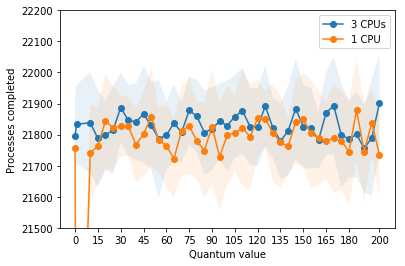

In [165]:
cpu3_mean_procs_completed,cpu3_std_procs_completed = zip(*cpu3_procs_completed)
cpu1_mean_procs_completed,cpu1_std_procs_completed = zip(*cpu1_procs_completed)

plt.plot(const_qs,cpu3_mean_procs_completed,label='3 CPUs',marker='o')
plt.fill_between(const_qs,
                 np.array(cpu3_mean_procs_completed) - np.array(cpu3_std_procs_completed),
                 np.array(cpu3_mean_procs_completed) + np.array(cpu3_std_procs_completed),
                 alpha=0.1)
plt.fill_between(const_qs,
                 np.array(cpu1_mean_procs_completed) - np.array(cpu1_std_procs_completed),
                 np.array(cpu1_mean_procs_completed) + np.array(cpu1_std_procs_completed),
                 alpha=0.1)
plt.plot(const_qs,cpu1_mean_procs_completed,label='1 CPU',marker='o')

plt.legend()
plt.xticks(const_qs[::3][:-1] + [const_qs[-1]], const_qs[::3][:-1] + [const_qs[-1]])
plt.ylim(21500,22200)
plt.xlabel('Quantum value')
plt.ylabel('Processes completed')
plt.show()

In [166]:
#ax1.set_ylim(-1,30)
#ax2.set_ylim(-1,5000)
@cache_handle
def find_best_throughput_per_t(tp_dict, wts, qs):
    best_q = 0
    max_tp = float('-inf')
    best_tp = None
    best_wt = None
    for q, idx in zip(tp_dict,qs):
        ptype2tp = dict()
        for ptype in q:
            throughput_vals = []
            Ts = []
            cum_sum = 0
            for t,nprocs_completed in sorted(q[ptype].items(),key=lambda it:it[0]):
                mean, std = nprocs_completed
                cum_sum += mean
                tp = cum_sum/t
                #print(t, nprocs_completed)
                Ts.append(t)
                throughput_vals.append(tp)
            ptype2tp[ptype] = [Ts, throughput_vals]
        avg_final_tp = sum([ptype2tp[ptype][1][-1] for ptype in q])
        if avg_final_tp > max_tp:
            max_tp = avg_final_tp
            best_tp = ptype2tp
            best_q= idx
            best_wt = wts[0]
    print(best_q, max_tp)
    return best_tp, best_wt, best_q

#def find_best_wait_time_per_t
best_tp_1cpus, bestwt_1cpu, best_q_1cpus = find_best_throughput_per_t(os.path.join(cpu1,'throughput_max.bin'),cpu1_tp,cpu1_wt, const_qs)
best_tp_3cpus, bestwt_3cpu, best_q_3cpus = find_best_throughput_per_t(os.path.join(cpu3,'throughput_max.bin'),cpu3_tp,cpu1_wt, const_qs)

batchInteractiveMalloc_constantQ_1cpu/throughput_max.bin is cached!
batchInteractiveMalloc_constantQ_3cpu/throughput_max.bin is cached!


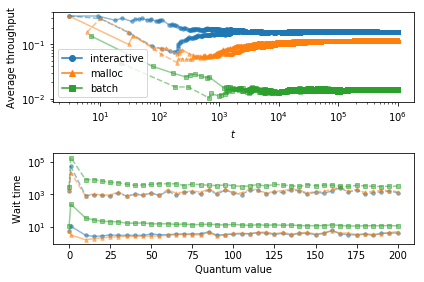

In [167]:
markers = ['o','^','s']
ptypes = list(best_tp_1cpus.keys())
ptype2marker = {ptype:markers[i] for i,ptype in enumerate(ptypes)}
ptype2color  = {ptype:f"C{i}" for i,ptype in enumerate(ptypes)}

def plot_wt_per_q(ax,wt,**kwargs):
    qs = const_qs
    ptype2wt = {ptype:[] for ptype in wt[0]}
    for wt_dict in wt:
        for ptype in ptype2wt:
            ptype2wt[ptype].append(wt_dict[ptype])

    for ptype in ptype2wt:
        mean, std = zip(*ptype2wt[ptype])
        #print(mean[:5])
        ax.plot(qs, mean, label=ptype, 
                color=ptype2color[ptype],
                marker=ptype2marker[ptype],
                markersize=3.5,
                **kwargs)
        #ax.set_title(label)
        
def plot_wt(ax,best_wt,**kwargs):
    
    for ptype in best_wt:
        wait_times, std_wt = zip(*best_wt[ptype])
        ax.plot(wait_times, label=ptype,
                color=ptype2color[ptype],
                markersize=3.5,
                marker=ptype2marker[ptype],**kwargs)
        
def plot_tp(ax, best_tp, **kwargs):
    for ptype in best_tp:
        X, y = best_tp[ptype]
        X, y = X[::2], y[::2]
        ax.plot(X,y,label=ptype,
                color=ptype2color[ptype],
                markersize=3.5,
                marker=ptype2marker[ptype], **kwargs)#,marker='o',markersize=0.55,linestyle='')
    #ax.set_xscale('log')
    #ax.set_yscale('log')
    #ax.set_title(rf"{title} $Q = {best_q}$")
    
fig, (ax1, ax2) = plt.subplots(2,1)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_yscale('log')

ax1.set_xlabel("$t$")
ax1.set_ylabel('Average throughput')

ax2.set_xlabel('Quantum value')
ax2.set_ylabel('Wait time')
cpu1_kw = {'alpha':0.5, 'linestyle':'--'}
cpu3_kw = {'alpha':0.5}
plot_tp(ax1,best_tp_1cpus,**cpu1_kw)
plot_tp(ax1,best_tp_3cpus,**cpu3_kw)
plot_wt_per_q(ax2,cpu1_wt, **cpu1_kw)
plot_wt_per_q(ax2,cpu3_wt, **cpu3_kw)
custom_lines = [Line2D([0],[0],
                       color=ptype2color[ptype],
                       marker=ptype2marker[ptype]) for ptype in ptypes]
ax1.legend(custom_lines, ptypes)
plt.tight_layout()
plt.show()